# Step Identifier

## Why
Getting to know each step taken is key towards measuring its *quality and consequence* for a gait event during a walking session. As presented in [Fast.ai's Fastbook](https://nbviewer.org/github/fastai/fastbook/blob/master/01_intro.ipynb#Image-Recognizers-Can-Tackle-Non-Image-Tasks) literature, time series could be transformed into images that could be used to train a recognizer to identify and predict over, using capacity built for that domain.

## Brainstorm

* From a pre captured session, get an image based dataset where each sample represents a second of 3 axis waves stamped as an image. Something like the following.

![Figure 1](./per-second.png)

*  Group samples into categories (using techniques such as `from scipy.signal import find_peaks`) to get a big pictyure on how distribution works. Identifying  and differentiating steps per origin.

* [defer-for-later] Match against tri-axial device gathered data, merging the corresponding dat segment, into a single row. This will add features to each sample.

* To each origin (n, m or 1, 2), label it.

* Train a prediction model. Measure it 80/20.

* Compare models between simple (per second) and extended (half-second displaced `window`) datasets 

In [1]:
# importing libraries
%matplotlib inline
import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv("../datasets/wit-10hz.csv", sep='\t')
df_raw.columns = ["time", "acx", "acy", "acz","gyx", "gyy", "gyz", "roll", "pitch", "yaw"]
df_raw.drop(["gyx", "gyy", "gyz", "roll", "pitch", "yaw"], axis=1, inplace=True)

df_raw['timedf'] = pd.to_datetime(df_raw['time'])
df_raw.info()
df_raw.drop('time', axis=1, inplace=True)

# Cheap tri-axial acceleormeter normalization
df_raw['sac'] = np.sqrt(np.power(df_raw['acx'], 2) + np.power(df_raw['acy'], 2) + np.power(df_raw['acz'], 2))

df_raw.columns = ["acx", "acy", "acz", "time", "sac"]

df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64892 entries, 0 to 64891
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    64892 non-null  object        
 1   acx     64892 non-null  float64       
 2   acy     64892 non-null  float64       
 3   acz     64892 non-null  float64       
 4   timedf  64892 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.5+ MB


,acx,acy,acz,time,sac
0,0.094727,0.076172,0.029297,2021-05-30 11:04:36.586,0.125034
1,0.114746,0.064453,0.098633,2021-05-30 11:04:36.670,0.164467
2,0.091309,0.042969,0.109863,2021-05-30 11:04:36.760,0.149176
3,0.091309,0.054688,0.110840,2021-05-30 11:04:36.879,0.153667
4,0.007812,0.028809,0.062012,2021-05-30 11:04:36.970,0.068822


## Experimenting 'windowing'

> No working nor conclusive work yet.

In [3]:
# y_rolling_avg = df_result['sac'].rolling(window=5).mean()
# #plt.plot(x, y)
# #plt.figure(10,5)
# #plt.plot(x, y_rolling_avg, color='red')
# sns.lineplot(y = 'sac', x = 'sac', data = y_rolling_avg)
# plt.show()

Per window of interest, we'll collect
* Accelerometer agg (Mean, Max & Min)
* Window start (Min) and End date (Max)

In [4]:
# TODO: optimize this block.

_HALF_SEC = 5 # for a 10hz capture

agg_array = np.array([0,0,0,0,0])
for i in range(0,len(df_raw), _HALF_SEC):
    to_add = np.array(
        [df_raw.iloc[i:i+4,4].mean(),
         df_raw.iloc[i:i+4,4].max(),
         df_raw.iloc[i:i+4,4].min(),
         df_raw.iloc[i:i+4,3].min(),
         df_raw.iloc[i:i+4,3].max()])
    agg_array = np.vstack((agg_array, to_add))
agg_array = np.delete(agg_array, 0, axis=0)

In [5]:
df_raw_agg = pd.DataFrame(agg_array, columns=['sac_mean', 'sac_max', 'sac_min', 'first_event', 'last_event'])
df_raw_agg['time_delta'] = (df_raw_agg['first_event'] - df_raw_agg['first_event'].min())  / np.timedelta64(1,'D')
df_raw_agg[['sac_mean', 'sac_max', 'sac_min']] = df_raw_agg[['sac_mean', 'sac_max', 'sac_min']].astype(float, errors = 'raise')
df_raw_agg.drop(["first_event", "last_event"], axis=1, inplace=True)
df_raw_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12979 entries, 0 to 12978
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sac_mean    12979 non-null  float64
 1   sac_max     12979 non-null  float64
 2   sac_min     12979 non-null  float64
 3   time_delta  12979 non-null  float64
dtypes: float64(4)
memory usage: 405.7 KB


### 1. Clustering using Tslearn

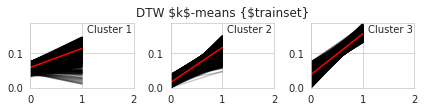

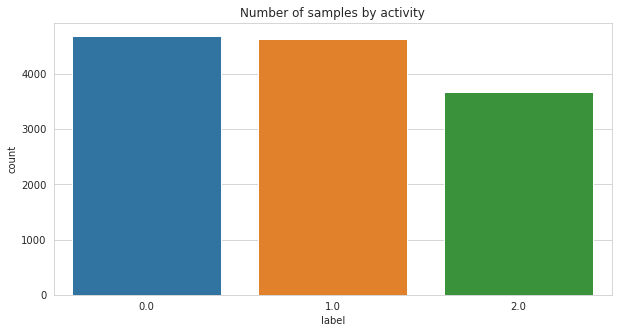

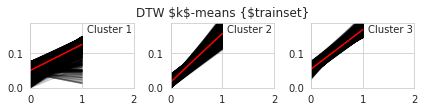

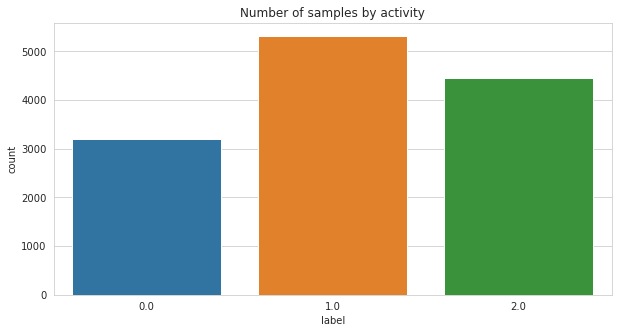

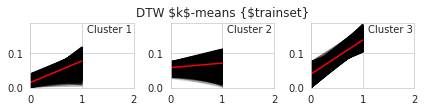

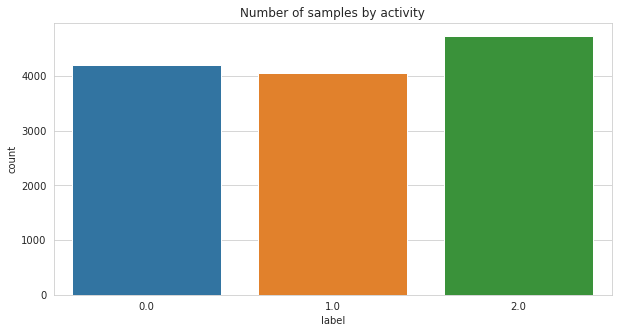

In [7]:
from tslearn.clustering import TimeSeriesKMeans

for i in range(3):
    
    X_train = df_raw_agg.iloc[:, [3,i]].to_numpy()

    km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=50)
    labels = km.fit_predict(X_train)

    sz = X_train.shape[1]

    plt.figure()
    for yi in range(3):
        plt.subplot(3, 3, 7 + yi)
        for xx in X_train[labels == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(0, 0.19)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("DTW $k$-means {$trainset}")

    plt.tight_layout()
    plt.show()

    result = np.concatenate((X_train, labels[:,None]),axis=1)

    df_result = pd.DataFrame(result)
    df_result.columns = ['delta','sac','label']
    sns.set_style("whitegrid")
    plt.figure(figsize = (10, 5))
    sns.countplot(x = 'label', data = df_result)
    plt.title('Number of samples by activity')
    plt.show()

### Get images per window and stack against what we have up to this point

In [ ]:
# for i in range(0,60):
#     current_second = df_raw_micro[(df_raw_micro['second'] == i)]
#     plt.figure(figsize=(10,3))
#     # sns.lineplot(y = 'acx', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acy', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acz', x = 'time', data = current_second)
#     sns.lineplot(y = 'sac', x = 'time', data = current_second)
#     # plt.legend(['x-axis', 'y-axis', 'z-axis'])
#     # plt.ylabel(i)
#     # plt.title(i, fontsize = 15)
#     plt.show()